<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/nlp-with-transformers/blob/main/08_model-compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

In [1]:
# 코랩이나 캐글을 사용한다면 이 셀의 주석을 제거하고 실행하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=8)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 569, done.
remote: Counting objects: 100% (303/303), done.
remote: Compressing objects: 100% (196/196), done.
remote: Total 569 (delta 183), reused 184 (delta 107), pack-reused 266
Receiving objects: 100% (569/569), 49.04 MiB | 10.91 MiB/s, done.
Resolving deltas: 100% (282/282), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.26.1
Using datasets v2.10.1
Using accelerate v0.16.0
Using optuna v3.1.0
Using onnxruntime v1.14.1
Using onnx v1.13.1


# 효율적인 트랜스포머 구축

<img alt="Scaling BERT at Roblox" caption="How Roblox scaled BERT with knowledge distillation, dynamic padding, and weight quantization (photo courtesy of Roblox employees Quoc N. Le and Kip Kaehler)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_roblox.png?raw=1" id="roblox"/>

## 의도 탐지 예제

<img alt="Out of Scope Query" width="400" caption="Three exchanges between a human (right) and a text-based assistant (left) for personal finance (courtesy of Stefan Larson et al.)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_oos.png?raw=1" id="oos"/> 

In [2]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

In [3]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in 
Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490034818649292}]

## 벤치마크 클래스 만들기

In [4]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type
        
    def compute_accuracy(self):
        # 나중에 정의합니다
        pass    

    def compute_size(self):
        # 나중에 정의합니다
        pass

    def time_pipeline(self):
        # 나중에 정의합니다
        pass
    
    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

In [5]:
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus")

Generating train split:   0%|          | 0/15250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5500 [00:00<?, ? examples/s]

Dataset clinc_oos downloaded and prepared to /root/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [7]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])

'transfer'

In [8]:
from datasets import load_metric 

accuracy_score = load_metric("accuracy")

<ipython-input-8-2ddb94fb810d>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_score = load_metric("accuracy")


In [9]:
def compute_accuracy(self):
    """PerformanceBenchmark.compute_accuracy() 메서드를 오버라이드합니다"""
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"테스트 세트 정확도 - {accuracy['accuracy']:.3f}")
    return accuracy

PerformanceBenchmark.compute_accuracy = compute_accuracy

In [10]:
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.weight',
 tensor([[-1.0526e-02, -3.2215e-02,  2.2097e-02,  ..., -6.0953e-03,
           4.6521e-03,  2.9844e-02],
         [-1.4964e-02, -1.0915e-02,  5.2396e-04,  ...,  3.2047e-05,
          -2.6890e-02, -2.1943e-02],
         [-2.9640e-02, -3.7842e-03, -1.2582e-02,  ..., -1.0917e-02,
           3.1152e-02, -9.7786e-03],
         ...,
         [-1.5116e-02, -3.3226e-02,  4.2063e-02,  ..., -5.2652e-03,
           1.1093e-02,  2.9703e-03],
         [-3.6809e-02,  5.6848e-02, -2.6544e-02,  ..., -4.0114e-02,
           6.7487e-03,  1.0511e-03],
         [-2.4961e-02,  1.4747e-03, -5.4271e-02,  ...,  2.0004e-02,
           2.3981e-02, -4.2880e-02]]))

In [11]:
import torch
from pathlib import Path

def compute_size(self):
    """PerformanceBenchmark.compute_size() 메서드를 오버라이드합니다"""
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    # 메가바이트 단위로 크기를 계산합니다
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    # 임시 파일을 삭제합니다
    tmp_path.unlink()
    print(f"모델 크기 (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}

PerformanceBenchmark.compute_size = compute_size

In [12]:
from time import perf_counter

for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query)
    latency = perf_counter() - start_time
    print(f"레이턴시 (ms) - {1000 * latency:.3f}")

레이턴시 (ms) - 127.099
레이턴시 (ms) - 132.454
레이턴시 (ms) - 122.870


In [13]:
import numpy as np

def time_pipeline(self, query="What is the pin number for my account?"):
    """PerformanceBenchmark.time_pipeline() 메서드를 오버라이드합니다d"""
    latencies = []
    # 워밍업
    for _ in range(10):
        _ = self.pipeline(query)
    # 실행 측정
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # 통게 계산
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"평균 레이턴시 (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

PerformanceBenchmark.time_pipeline = time_pipeline

In [14]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

모델 크기 (MB) - 418.15
평균 레이턴시 (ms) - 161.44 +\- 80.74
테스트 세트 정확도 - 0.867


## 지식 정제로 모델 크기 줄이기

### 미세 튜닝을 위한 지식 정제

<img alt="Soft Probabilities" caption="Comparison of a hard label that is one-hot encoded (left), softmax probabilities (middle), and softened class probabilities (right)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_soft-probs.png?raw=1" id="soft-probs"/> 

<img alt="Knowledge distillation" caption="The knowledge distillation process" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_kd.png?raw=1" id="kd"/> 

### 사전 훈련을 위한 지식 정제

### 지식 정제 트레이너 만들기

In [15]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

In [16]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs = inputs.to(device)
        outputs_stu = model(**inputs)
        # 스튜던트의 크로스 엔트로피 손실과 로짓을 추출합니다
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # 티처의 로짓을 추출합니다
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # 확률을 부드럽게하고 정제 손실을 계산합니다
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        # 가중 평균된 스튜던트 손실을 반환합니다
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

### 좋은 스튜던트 초기화 선택하기

In [17]:
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

Map:   0%|          | 0/15250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

In [18]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [19]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

In [20]:
batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt, evaluation_strategy = "epoch", 
    num_train_epochs=5, learning_rate=2e-5, 
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size, alpha=1, weight_decay=0.01, 
    push_to_hub=True)

In [21]:
student_training_args.logging_steps = len(clinc_enc['train']) // batch_size
student_training_args.disable_tqdm = False
student_training_args.save_steps = 1e9
# 트랜스포머 4.23.0 버전부터 로깅 수준을 문자열로 지정해야 합니다.
# student_training_args.log_level = 40
student_training_args.log_level = 'error'

In [22]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [23]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [24]:
from transformers import AutoConfig

num_labels = intents.num_classes
student_config = (AutoConfig
                  .from_pretrained(student_ckpt, num_labels=num_labels, 
                                   id2label=id2label, label2id=label2id))

In [25]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(student_ckpt, config=student_config).to(device))

In [26]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))

In [27]:
distilbert_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distilbert_trainer.train()

Cloning https://huggingface.co/haesun/distilbert-base-uncased-finetuned-clinc into local empty directory.


Download file pytorch_model.bin:   0%|          | 8.00k/256M [00:00<?, ?B/s]

Download file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664672869.b05fa2490007.73.26:  50%|####9  …

Download file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664673573.b05fa2490007.73.32: 100%|#######…

Download file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664671657.b05fa2490007.73.8: 100%|########…

Download file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664674393.b05fa2490007.73.42:  51%|#####1 …

Download file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664672320.b05fa2490007.73.16:  52%|#####2 …

Download file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664670918.b05fa2490007.73.4: 100%|########…

Download file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664671306.b05fa2490007.73.6: 100%|########…

Download file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664672007.b05fa2490007.73.10: 100%|#######…

Download file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664673260.b05fa2490007.73.28: 100%|#######…

Download file runs/Mar07_04-03-45_de60d670a146/events.out.tfevents.1678161907.de60d670a146.128.0: 100%|#######…

Download file runs/Jan09_02-58-55_854eee514b2e/events.out.tfevents.1673234345.854eee514b2e.389.0: 100%|#######…

Download file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664669938.b05fa2490007.73.0: 100%|########…

Clean file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664671657.b05fa2490007.73.8:   6%|6         |…

Download file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664670606.b05fa2490007.73.2: 100%|########…

Clean file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664673573.b05fa2490007.73.32:   6%|6         …

Download file runs/Oct02_02-03-49_b05fa2490007/events.out.tfevents.1664676238.b05fa2490007.2088.0: 100%|######…

Download file runs/Oct01_15-59-56_a0ae37370794/events.out.tfevents.1664640373.a0ae37370794.74.0: 100%|########…

Download file runs/Aug09_13-22-30_380ffc6f762a/events.out.tfevents.1660052145.380ffc6f762a.397.0: 100%|#######…

Download file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664674004.b05fa2490007.73.36: 100%|#######…

Download file runs/Aug09_07-36-51_cb6f1501ac1a/events.out.tfevents.1660030697.cb6f1501ac1a.543.15: 100%|######…

Clean file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664670918.b05fa2490007.73.4:   6%|6         |…

Clean file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664671306.b05fa2490007.73.6:   6%|6         |…

Download file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664672710.b05fa2490007.73.20: 100%|#######…

Download file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664674240.b05fa2490007.73.40: 100%|#######…

Download file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664672241.b05fa2490007.73.12: 100%|#######…

Clean file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664672869.b05fa2490007.73.26:   6%|6         …

Download file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664672829.b05fa2490007.73.24: 100%|#######…

Download file runs/Aug09_09-36-57_6eee1db3d806/events.out.tfevents.1660037960.6eee1db3d806.72.0: 100%|########…

Clean file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664674393.b05fa2490007.73.42:   6%|6         …

Download file runs/Aug09_06-28-42_cb6f1501ac1a/events.out.tfevents.1660026530.cb6f1501ac1a.543.0: 100%|#######…

Download file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664672789.b05fa2490007.73.22: 100%|#######…

Download file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664672280.b05fa2490007.73.14: 100%|#######…

Clean file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664672320.b05fa2490007.73.16:   7%|6         …

Download file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664672670.b05fa2490007.73.18: 100%|#######…

Download file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664673533.b05fa2490007.73.30: 100%|#######…

Download file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664674200.b05fa2490007.73.38: 100%|#######…

Clean file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664672007.b05fa2490007.73.10:   7%|7         …

Download file runs/Mar07_07-16-58_de60d670a146/events.out.tfevents.1678173491.de60d670a146.128.44: 100%|######…

Download file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664673964.b05fa2490007.73.34: 100%|#######…

Download file runs/Aug09_06-03-19_cb6f1501ac1a/events.out.tfevents.1660025667.cb6f1501ac1a.71.0: 100%|########…

Download file runs/Mar07_04-03-45_de60d670a146/1678161907.8670664/events.out.tfevents.1678161907.de60d670a146.…

Clean file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664673260.b05fa2490007.73.28:   7%|6         …

Download file runs/Jan09_02-58-55_854eee514b2e/1673234345.274574/events.out.tfevents.1673234345.854eee514b2e.3…

Clean file runs/Mar07_04-03-45_de60d670a146/events.out.tfevents.1678161907.de60d670a146.128.0:   7%|7         …

Download file runs/Aug09_06-03-19_cb6f1501ac1a/events.out.tfevents.1660025694.cb6f1501ac1a.71.2: 100%|########…

Download file runs/Oct02_00-16-31_b05fa2490007/1664674004.4771154/events.out.tfevents.1664674004.b05fa2490007.…

Download file runs/Oct02_00-16-31_b05fa2490007/1664672789.36423/events.out.tfevents.1664672789.b05fa2490007.73…

Download file runs/Oct02_00-16-31_b05fa2490007/1664673964.4122996/events.out.tfevents.1664673964.b05fa2490007.…

Clean file runs/Jan09_02-58-55_854eee514b2e/events.out.tfevents.1673234345.854eee514b2e.389.0:   7%|7         …

Download file runs/Oct02_00-16-31_b05fa2490007/1664672670.7189837/events.out.tfevents.1664672670.b05fa2490007.…

Download file runs/Oct02_00-16-31_b05fa2490007/1664674240.8988304/events.out.tfevents.1664674240.b05fa2490007.…

Clean file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664669938.b05fa2490007.73.0:   7%|7         |…

Download file runs/Oct02_00-16-31_b05fa2490007/1664674393.145688/events.out.tfevents.1664674393.b05fa2490007.7…

Download file runs/Oct02_00-16-31_b05fa2490007/1664672241.1342566/events.out.tfevents.1664672241.b05fa2490007.…

Download file runs/Oct02_00-16-31_b05fa2490007/1664672280.7750466/events.out.tfevents.1664672280.b05fa2490007.…

Clean file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664670606.b05fa2490007.73.2:   7%|6         |…

Download file runs/Oct02_02-03-49_b05fa2490007/1664676238.8848484/events.out.tfevents.1664676238.b05fa2490007.…

Download file runs/Oct02_00-16-31_b05fa2490007/1664672007.2954679/events.out.tfevents.1664672007.b05fa2490007.…

Clean file runs/Oct02_02-03-49_b05fa2490007/events.out.tfevents.1664676238.b05fa2490007.2088.0:   7%|7        …

Download file runs/Oct02_00-16-31_b05fa2490007/1664671657.1552744/events.out.tfevents.1664671657.b05fa2490007.…

Download file runs/Oct02_00-16-31_b05fa2490007/1664671306.6220074/events.out.tfevents.1664671306.b05fa2490007.…

Download file runs/Oct02_00-16-31_b05fa2490007/1664672320.4486637/events.out.tfevents.1664672320.b05fa2490007.…

Download file runs/Oct02_00-16-31_b05fa2490007/1664670918.0620842/events.out.tfevents.1664670918.b05fa2490007.…

Download file runs/Oct02_00-16-31_b05fa2490007/1664670606.7468364/events.out.tfevents.1664670606.b05fa2490007.…

Clean file runs/Oct01_15-59-56_a0ae37370794/events.out.tfevents.1664640373.a0ae37370794.74.0:   7%|7         |…

Download file runs/Mar07_07-16-58_de60d670a146/1678173491.2541318/events.out.tfevents.1678173491.de60d670a146.…

Download file runs/Oct02_00-16-31_b05fa2490007/1664669938.853798/events.out.tfevents.1664669938.b05fa2490007.7…

Clean file runs/Aug09_13-22-30_380ffc6f762a/events.out.tfevents.1660052145.380ffc6f762a.397.0:   7%|7         …

Download file runs/Oct02_00-16-31_b05fa2490007/1664673573.716571/events.out.tfevents.1664673573.b05fa2490007.7…

Download file runs/Oct02_00-16-31_b05fa2490007/1664672710.3362494/events.out.tfevents.1664672710.b05fa2490007.…

Download file runs/Oct02_00-16-31_b05fa2490007/1664672869.729377/events.out.tfevents.1664672869.b05fa2490007.7…

Download file runs/Oct02_00-16-31_b05fa2490007/1664673260.8125339/events.out.tfevents.1664673260.b05fa2490007.…

Clean file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664674004.b05fa2490007.73.36:   7%|7         …

Download file runs/Oct02_00-16-31_b05fa2490007/1664674200.9357858/events.out.tfevents.1664674200.b05fa2490007.…

Download file runs/Oct02_00-16-31_b05fa2490007/1664673533.960311/events.out.tfevents.1664673533.b05fa2490007.7…

Clean file runs/Aug09_07-36-51_cb6f1501ac1a/events.out.tfevents.1660030697.cb6f1501ac1a.543.15:   8%|7        …

Download file runs/Oct01_15-59-56_a0ae37370794/1664640373.308095/events.out.tfevents.1664640373.a0ae37370794.7…

Download file runs/Aug09_13-22-30_380ffc6f762a/1660052145.0695257/events.out.tfevents.1660052145.380ffc6f762a.…

Download file runs/Aug09_06-28-42_cb6f1501ac1a/1660026530.491574/events.out.tfevents.1660026530.cb6f1501ac1a.5…

Download file runs/Aug09_07-36-51_cb6f1501ac1a/1660030697.3059525/events.out.tfevents.1660030697.cb6f1501ac1a.…

Clean file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664672710.b05fa2490007.73.20:   8%|8         …

Download file runs/Aug09_09-36-57_6eee1db3d806/1660037960.065583/events.out.tfevents.1660037960.6eee1db3d806.7…

Download file runs/Oct02_00-16-31_b05fa2490007/1664672829.4861207/events.out.tfevents.1664672829.b05fa2490007.…

Download file runs/Aug09_06-03-19_cb6f1501ac1a/1660025667.2669258/events.out.tfevents.1660025667.cb6f1501ac1a.…

Download file runs/Aug09_06-03-19_cb6f1501ac1a/1660025694.9731698/events.out.tfevents.1660025694.cb6f1501ac1a.…

Clean file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664674240.b05fa2490007.73.40:   9%|8         …

Clean file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664672241.b05fa2490007.73.12:   9%|8         …

Clean file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664672829.b05fa2490007.73.24:   9%|8         …

Clean file runs/Aug09_09-36-57_6eee1db3d806/events.out.tfevents.1660037960.6eee1db3d806.72.0:   8%|7         |…

Clean file runs/Aug09_06-28-42_cb6f1501ac1a/events.out.tfevents.1660026530.cb6f1501ac1a.543.0:   8%|7         …

Clean file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664672789.b05fa2490007.73.22:   9%|8         …

Clean file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664672280.b05fa2490007.73.14:   9%|8         …

Clean file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664672670.b05fa2490007.73.18:   9%|8         …

Clean file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664673533.b05fa2490007.73.30:   9%|8         …

Download file training_args.bin: 100%|##########| 3.50k/3.50k [00:00<?, ?B/s]

Clean file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664674200.b05fa2490007.73.38:   9%|8         …

Clean file runs/Mar07_07-16-58_de60d670a146/events.out.tfevents.1678173491.de60d670a146.128.44:   7%|7        …

Clean file runs/Oct02_00-16-31_b05fa2490007/events.out.tfevents.1664673964.b05fa2490007.73.34:   9%|8         …

Clean file runs/Aug09_06-03-19_cb6f1501ac1a/events.out.tfevents.1660025667.cb6f1501ac1a.71.0:  10%|9         |…

Clean file runs/Mar07_04-03-45_de60d670a146/1678161907.8670664/events.out.tfevents.1678161907.de60d670a146.128…

Clean file runs/Jan09_02-58-55_854eee514b2e/1673234345.274574/events.out.tfevents.1673234345.854eee514b2e.389.…

Clean file runs/Aug09_06-03-19_cb6f1501ac1a/events.out.tfevents.1660025694.cb6f1501ac1a.71.2:  10%|9         |…

Clean file runs/Oct02_00-16-31_b05fa2490007/1664674004.4771154/events.out.tfevents.1664674004.b05fa2490007.73.…

Clean file runs/Oct02_00-16-31_b05fa2490007/1664672789.36423/events.out.tfevents.1664672789.b05fa2490007.73.23…

Clean file runs/Oct02_00-16-31_b05fa2490007/1664673964.4122996/events.out.tfevents.1664673964.b05fa2490007.73.…

Clean file runs/Oct02_00-16-31_b05fa2490007/1664672670.7189837/events.out.tfevents.1664672670.b05fa2490007.73.…

Clean file runs/Oct02_00-16-31_b05fa2490007/1664674240.8988304/events.out.tfevents.1664674240.b05fa2490007.73.…

Clean file runs/Oct02_00-16-31_b05fa2490007/1664674393.145688/events.out.tfevents.1664674393.b05fa2490007.73.4…

Clean file runs/Oct02_00-16-31_b05fa2490007/1664672241.1342566/events.out.tfevents.1664672241.b05fa2490007.73.…

Clean file runs/Oct02_00-16-31_b05fa2490007/1664672280.7750466/events.out.tfevents.1664672280.b05fa2490007.73.…

Clean file runs/Oct02_02-03-49_b05fa2490007/1664676238.8848484/events.out.tfevents.1664676238.b05fa2490007.208…

Clean file runs/Oct02_00-16-31_b05fa2490007/1664672007.2954679/events.out.tfevents.1664672007.b05fa2490007.73.…

Clean file runs/Oct02_00-16-31_b05fa2490007/1664671657.1552744/events.out.tfevents.1664671657.b05fa2490007.73.…

Clean file runs/Oct02_00-16-31_b05fa2490007/1664671306.6220074/events.out.tfevents.1664671306.b05fa2490007.73.…

Clean file runs/Oct02_00-16-31_b05fa2490007/1664672320.4486637/events.out.tfevents.1664672320.b05fa2490007.73.…

Clean file runs/Oct02_00-16-31_b05fa2490007/1664670918.0620842/events.out.tfevents.1664670918.b05fa2490007.73.…

Clean file runs/Oct02_00-16-31_b05fa2490007/1664670606.7468364/events.out.tfevents.1664670606.b05fa2490007.73.…

Clean file runs/Mar07_07-16-58_de60d670a146/1678173491.2541318/events.out.tfevents.1678173491.de60d670a146.128…

Clean file runs/Oct02_00-16-31_b05fa2490007/1664669938.853798/events.out.tfevents.1664669938.b05fa2490007.73.1…

Clean file runs/Oct02_00-16-31_b05fa2490007/1664673573.716571/events.out.tfevents.1664673573.b05fa2490007.73.3…

Clean file runs/Oct02_00-16-31_b05fa2490007/1664672710.3362494/events.out.tfevents.1664672710.b05fa2490007.73.…

Clean file runs/Oct02_00-16-31_b05fa2490007/1664672869.729377/events.out.tfevents.1664672869.b05fa2490007.73.2…

Clean file runs/Oct02_00-16-31_b05fa2490007/1664673260.8125339/events.out.tfevents.1664673260.b05fa2490007.73.…

Clean file runs/Oct02_00-16-31_b05fa2490007/1664674200.9357858/events.out.tfevents.1664674200.b05fa2490007.73.…

Clean file runs/Oct02_00-16-31_b05fa2490007/1664673533.960311/events.out.tfevents.1664673533.b05fa2490007.73.3…

Clean file runs/Oct01_15-59-56_a0ae37370794/1664640373.308095/events.out.tfevents.1664640373.a0ae37370794.74.1…

Clean file runs/Aug09_13-22-30_380ffc6f762a/1660052145.0695257/events.out.tfevents.1660052145.380ffc6f762a.397…

Clean file runs/Aug09_06-28-42_cb6f1501ac1a/1660026530.491574/events.out.tfevents.1660026530.cb6f1501ac1a.543.…

Clean file runs/Aug09_07-36-51_cb6f1501ac1a/1660030697.3059525/events.out.tfevents.1660030697.cb6f1501ac1a.543…

Clean file runs/Aug09_09-36-57_6eee1db3d806/1660037960.065583/events.out.tfevents.1660037960.6eee1db3d806.72.1…

Clean file runs/Oct02_00-16-31_b05fa2490007/1664672829.4861207/events.out.tfevents.1664672829.b05fa2490007.73.…

Clean file runs/Aug09_06-03-19_cb6f1501ac1a/1660025667.2669258/events.out.tfevents.1660025667.cb6f1501ac1a.71.…

Clean file runs/Aug09_06-03-19_cb6f1501ac1a/1660025694.9731698/events.out.tfevents.1660025694.cb6f1501ac1a.71.…

Clean file training_args.bin:  29%|##8       | 1.00k/3.50k [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/256M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


TrainOutput(global_step=1590, training_loss=2.0514515375941054, metrics={'train_runtime': 297.607, 'train_samples_per_second': 256.21, 'train_steps_per_second': 5.343, 'total_flos': 413896353421488.0, 'train_loss': 2.0514515375941054, 'epoch': 5.0})

In [28]:
distilbert_trainer.push_to_hub("Training completed!")

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/haesun/distilbert-base-uncased-finetuned-clinc
   d8d5e23..517b221  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/haesun/distilbert-base-uncased-finetuned-clinc
   d8d5e23..517b221  main -> main



'https://huggingface.co/haesun/distilbert-base-uncased-finetuned-clinc/commit/517b22179f3deaac928d97b97a6f65a197a47216'

In [29]:
# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
finetuned_ckpt = "haesun/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

In [30]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 255.88
평균 레이턴시 (ms) - 39.04 +\- 1.99
테스트 세트 정확도 - 0.862


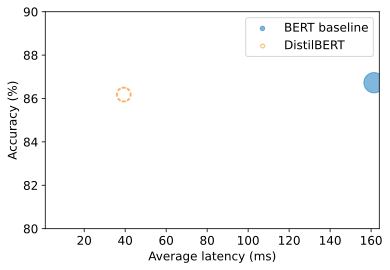

In [31]:
import pandas as pd

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # 현재 최적화 방법을 점선으로 그립니다
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        alpha=0.5, s=df_opt["size_mb"], label=idx, 
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        s=df_opt["size_mb"], label=idx, alpha=0.5)
            
    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    # 가장 느린 모델을 사용해 x 축 범위를 정합니다
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()
    
plot_metrics(perf_metrics, optim_type)

### 옵투나로 좋은 하이퍼파라미터 찾기

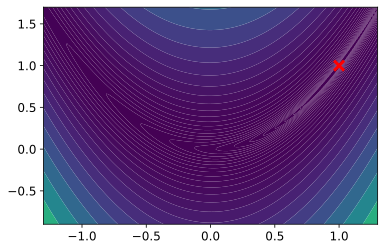

In [32]:
# 두 변수를 가진 로젠브록 함수 그래프
import matplotlib.pyplot as plt
import numpy as np

def f(x, y):
    return (1-x)**2+100*(y-x**2)**2
    
X, Y = np.meshgrid(np.linspace(-2, 2, 250), np.linspace(-1, 3, 250))
Z = f(X,Y)
_, ax = plt.subplots()
ax.plot([1], [1], 'x', mew=3, markersize=10, color="red")
ax.contourf(X, Y, Z, np.logspace(-1, 3, 30), cmap='viridis', extend="both")
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-0.9, 1.7)
plt.show()

In [33]:
def objective(trial):
    x = trial.suggest_float("x", -2, 2)
    y = trial.suggest_float("y", -2, 2)
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

In [34]:
import optuna 

study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2023-03-08 01:20:23,718] A new study created in memory with name: no-name-220e72bd-9397-40f1-bf25-fea4233d2922
[I 2023-03-08 01:20:23,727] Trial 0 finished with value: 2.1902444871782323 and parameters: {'x': -0.1499291252065107, 'y': 0.11564029550161647}. Best is trial 0 with value: 2.1902444871782323.
[I 2023-03-08 01:20:23,730] Trial 1 finished with value: 1234.6742729540977 and parameters: {'x': -1.8429262244506663, 'y': -0.10589654052702047}. Best is trial 0 with value: 2.1902444871782323.
[I 2023-03-08 01:20:23,732] Trial 2 finished with value: 322.79432638952096 and parameters: {'x': 1.1556671708846347, 'y': -0.46101373657945643}. Best is trial 0 with value: 2.1902444871782323.
[I 2023-03-08 01:20:23,736] Trial 3 finished with value: 229.1033111752009 and parameters: {'x': -1.5709634776360257, 'y': 0.9763047881379783}. Best is trial 0 with value: 2.1902444871782323.
[I 2023-03-08 01:20:23,739] Trial 4 finished with value: 70.41641411216591 and parameters: {'x': 0.991249341601

In [35]:
study.best_params

{'x': 0.9429817799920465, 'y': 0.8947741463913411}

In [36]:
def hp_space(trial):
    return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
        "alpha": trial.suggest_float("alpha", 0, 1),
        "temperature": trial.suggest_int("temperature", 2, 20)}

In [37]:
best_run = distilbert_trainer.hyperparameter_search(
    n_trials=20, direction="maximize", hp_space=hp_space)

[I 2023-03-08 01:20:44,524] A new study created in memory with name: no-name-c516b0c1-e78e-4e7b-83e4-5fed9ec58954
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-03-08 01:26:44,886] Trial 0 finished with value: 0.9035483870967742 and parameters: {'num_train_epochs': 6, 'alpha': 0.2673127926607517, 'temperature': 11}. Best is trial 0 with value: 0.9035483870967742.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-03-08 01:32:45,450] Trial 1 finished with value: 0.9041935483870968 and parameters: {'num_train_epochs': 6, 'alpha': 0.31197242407302384, 'temperature': 7}. Best is trial 1 with value: 0.9041935483870968.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-03-08 01:40:45,748] Trial 2 finished with value: 0.917741935483871 and parameters: {'num_train_epochs': 8, 'alpha': 0.3499381698998284, 'temperature': 12}. Best is trial 2 with value: 0.917741935483871.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-03-08 01:45:46,586] Trial 3 finished with value: 0.8938709677419355 and parameters: {'num_train_epochs': 5, 'alpha': 0.16086441059764123, 'temperature': 11}. Best is trial 2 with value: 0.917741935483871.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-03-08 01:50:47,472] Trial 4 finished with value: 0.9038709677419355 and parameters: {'num_train_epochs': 5, 'alpha': 0.406214067876429, 'temperature': 2}. Best is trial 2 with value: 0.917741935483871.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-03-08 01:52:47,856] Trial 5 pruned. 
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-03-08 01:53:48,962] Trial 6 pruned. 
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-03-08 02:01:49,416] Trial 7 finished with value: 0.922258064516129 and parameters: {'num_train_epochs': 8, 'alpha': 0.8335385790075832, 'temperature': 5}. Best is trial 7 with value: 0.922258064516129.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-03-08 02:11:53,380] Trial 8 finished with value: 0.9267741935483871 and parameters: {'num_train_epochs': 10, 'alpha': 0.2022198321798232, 'temperature': 9}. Best is trial 8 with value: 0.9267741935483871.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-03-08 02:21:55,265] Trial 9 pruned. 
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-03-08 02:22:56,041] Trial 10 pruned. 
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-03-08 02:29:56,753] Trial 11 pruned. 
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-03-08 02:36:57,487] Trial 12 pruned. 
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-03-08 02:45:57,471] Trial 13 finished with value: 0.9293548387096774 and parameters: {'num_train_epochs': 9, 'alpha': 0.9551297060479453, 'temperature': 2}. Best is trial 13 with value: 0.9293548387096774.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-03-08 02:54:56,923] Trial 14 finished with value: 0.9293548387096774 and parameters: {'num_train_epochs': 9, 'alpha': 0.699977195872304, 'temperature': 2}. Best is trial 13 with value: 0.9293548387096774.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-03-08 03:03:56,550] Trial 15 finished with value: 0.9293548387096774 and parameters: {'num_train_epochs': 9, 'alpha': 0.9684599227144317, 'temperature': 2}. Best is trial 13 with value: 0.9293548387096774.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-03-08 03:04:57,301] Trial 16 pruned. 
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-03-08 03:11:57,649] Trial 17 pruned. 
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-03-08 03:12:58,695] Trial 18 pruned. 
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[I 2023-03-08 03:19:59,017] Trial 19 pruned. 


In [38]:
print(best_run)

BestRun(run_id='13', objective=0.9293548387096774,
hyperparameters={'num_train_epochs': 9, 'alpha': 0.9551297060479453,
'temperature': 2})


In [39]:
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v)
    
# 정제된 모델을 저장할 새로운 저장소를 정의합니다
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

# 최적의 매개변수로 새로운 Trainer를 만듭니다
distil_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distil_trainer.train();

Cloning https://huggingface.co/haesun/distilbert-base-uncased-distilled-clinc into local empty directory.


Download file pytorch_model.bin:   0%|          | 8.00k/256M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 3.56k/3.56k [00:00<?, ?B/s]

Clean file training_args.bin:  28%|##8       | 1.00k/3.56k [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/256M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [40]:
distil_trainer.push_to_hub("Training complete")

Upload file pytorch_model.bin:   0%|          | 32.0k/256M [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 3.56k/3.56k [00:00<?, ?B/s]

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/haesun/distilbert-base-uncased-distilled-clinc
   c79729b..7dd3131  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/haesun/distilbert-base-uncased-distilled-clinc
   c79729b..7dd3131  main -> main

To https://huggingface.co/haesun/distilbert-base-uncased-distilled-clinc
   7dd3131..9bf4999  main -> main

   7dd3131..9bf4999  main -> main



'https://huggingface.co/haesun/distilbert-base-uncased-distilled-clinc/commit/7dd3131a37d06aa5797f2fd3350adc5436f06f07'

### 정제 모델 벤치마크 수행하기

In [41]:
# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
distilled_ckpt = "haesun/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 255.88
평균 레이턴시 (ms) - 38.94 +\- 1.97
테스트 세트 정확도 - 0.885


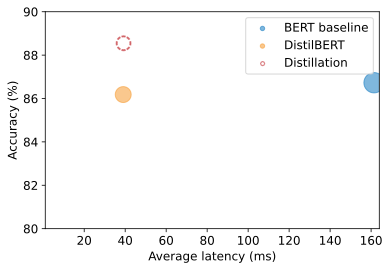

In [42]:
plot_metrics(perf_metrics, optim_type)

## 양자화로 모델 속도 높이기

### 사이드바: 부동 소수점 숫자 vs 고정 소수점 숫자

### End sidebar

<img alt="Mapping floating-point numbers to 8-bit integers" width="800" caption="Quantizing floating-point numbers as unsigned 8-bit integers (courtesy of Manas Sahni)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_fp32-to-int8.png?raw=1" id="fp32toint8"/>

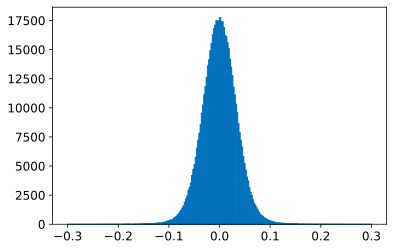

In [43]:
import matplotlib.pyplot as plt

state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3,0.3), edgecolor="C0")
plt.show()

In [44]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))

In [45]:
(weights / scale + zero_point).clamp(-128, 127).round().char()

tensor([[ -5,  -7,   0,  ...,  -6,  -4,   8],
        [  9,   2,   1,  ...,  -4,   7,   1],
        [ -9,  -6,   5,  ...,   0,   6,  -4],
        ...,
        [  5,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

In [46]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -7,   0,  ...,  -6,  -4,   8],
        [  9,   2,   1,  ...,  -4,   7,   1],
        [ -9,  -6,   5,  ...,   0,   6,  -4],
        ...,
        [  5,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

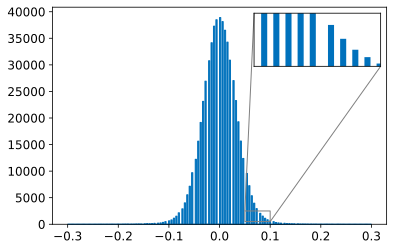

In [47]:
# 트랜스포머 가중치에서 양자화 효과
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

# 히스토그램 그리기
fig, ax = plt.subplots()
ax.hist(quantized_weights.dequantize().flatten().numpy(), 
         bins=250, range=(-0.3,0.3), edgecolor="C0");
# 확대 그림 만들기
axins = zoomed_inset_axes(ax, 5, loc='upper right')
axins.hist(quantized_weights.dequantize().flatten().numpy(), 
         bins=250, range=(-0.3,0.3));
x1, x2, y1, y2 = 0.05, 0.1, 500, 2500
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.axes.xaxis.set_visible(False)
axins.axes.yaxis.set_visible(False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.show()

In [48]:
%%timeit 
weights @ weights

17.5 ms ± 538 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [49]:
from torch.nn.quantized import QFunctional

q_fn = QFunctional()

In [50]:
%%timeit
q_fn.mul(quantized_weights, quantized_weights)

256 µs ± 40.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [51]:
import sys

sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

3.999755879241598

In [52]:
from torch.quantization import quantize_dynamic

# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
model_ckpt = "haesun/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt).to("cpu"))

model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

### 양자화된 모델의 벤치마크 수행하기

In [53]:
pipe = pipeline("text-classification", model=model_quantized, 
                tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 132.39
평균 레이턴시 (ms) - 17.12 +\- 1.96
테스트 세트 정확도 - 0.892


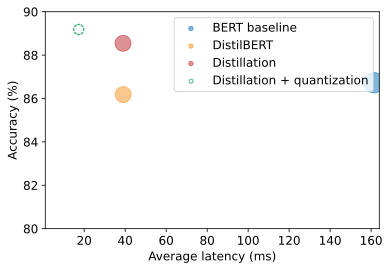

In [54]:
plot_metrics(perf_metrics, optim_type)

## ONNX와 ONNX 런타임으로 추론 최적화하기

<img alt="Example ONNX graph" width="500" caption="A section of the ONNX graph for BERT-base, visualized in Netron" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_bert-onnx.png?raw=1" id="bert-onnx"/>

<img alt="Architecture of the ONNX and ONNX Runtime ecosystem" width="500" caption="Architecture of the ONNX and ONNX Runtime ecosystem (courtesy of the ONNX Runtime team)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_onnx-ort.png?raw=1" id="onnx-ort"/>

In [55]:
import os
from psutil import cpu_count

os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"

In [56]:
from transformers.convert_graph_to_onnx import convert

# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
model_ckpt = "haesun/distilbert-base-uncased-distilled-clinc"
onnx_model_path = Path("onnx/model.onnx")
convert(framework="pt", model=model_ckpt, tokenizer=tokenizer, 
        output=onnx_model_path, opset=12, pipeline_name="text-classification")

/usr/local/lib/python3.8/dist-packages/transformers/convert_graph_to_onnx.py:380: FutureWarning: The `transformers.convert_graph_to_onnx` package is deprecated and will be removed in version 5 of Transformers
  warnings.warn(


ONNX opset version set to: 12
Loading pipeline (model: haesun/distilbert-base-uncased-distilled-clinc, tokenizer: DistilBertTokenizerFast(name_or_path='haesun/distilbert-base-uncased-distilled-clinc', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}))
Creating folder onnx
Using framework PyTorch: 1.13.1+cu116
Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch'}
Ensuring inputs are in correct order
head_mask is not present in the generated input list.
Generated inputs order: ['input_ids', 'attention_mask']


/usr/local/lib/python3.8/dist-packages/transformers/models/distilbert/modeling_distilbert.py:218: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  mask, torch.tensor(torch.finfo(scores.dtype).min)


In [57]:
from onnxruntime import (GraphOptimizationLevel, InferenceSession, 
                         SessionOptions)

def create_model_for_provider(model_path, provider="CPUExecutionProvider"): 
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session

In [58]:
onnx_model = create_model_for_provider(onnx_model_path)

In [59]:
inputs = clinc_enc["test"][:1]
del inputs["labels"]
logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape

(1, 151)

In [60]:
np.argmax(logits_onnx)

61

In [61]:
clinc_enc["test"][0]["labels"]

61

In [62]:
from scipy.special import softmax

class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        
    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy() 
                       for k, v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]

In [63]:
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

[{'label': 'car_rental', 'score': 0.9556557}]

In [64]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path
        
    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"모델 크기 (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

In [65]:
optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path="onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 255.98
평균 레이턴시 (ms) - 25.12 +\- 1.45
테스트 세트 정확도 - 0.885


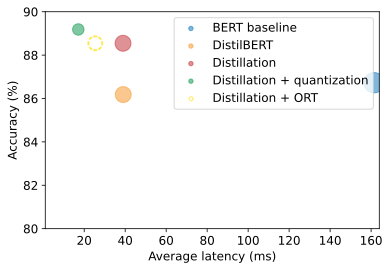

In [66]:
plot_metrics(perf_metrics, optim_type)

In [67]:
from onnxruntime.quantization import quantize_dynamic, QuantType

model_input = "onnx/model.onnx"
model_output = "onnx/model.quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.5/attention/MatMul]
Ignore MatM

In [68]:
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = "Distillation + ORT (quantized)"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type, 
                              model_path=model_output)
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 64.31
평균 레이턴시 (ms) - 15.56 +\- 4.24
테스트 세트 정확도 - 0.896


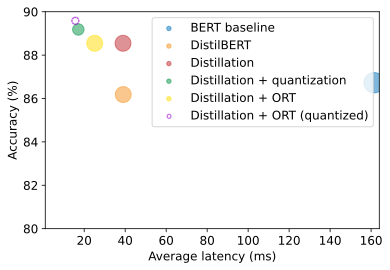

In [69]:
plot_metrics(perf_metrics, optim_type)

## 가중치 가지치기로 희소한 모델 만들기

### 심층 신경망의 희소성

<img alt="Network Pruning" width="500" caption="Weights and neurons before and after pruning (courtesy of Song Han)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_network-pruning.png?raw=1" id="network-pruning"/> 

### 가중치 가지치기 방법

#### 절댓값 가지치기

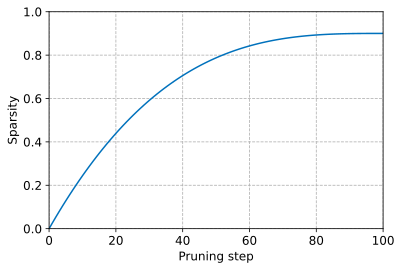

In [70]:
# 가지치기에 사용되는 세제곱 희소성 스케줄러
import numpy as np
import matplotlib.pyplot as plt

def _sparsity(t, t_0=0, dt=1, s_i=0, s_f=0.9, N=100):
    return s_f + (s_i - s_f) * (1 - (t - t_0) / (N * dt))**3

steps = np.linspace(0,100,100)
values = [_sparsity(t) for t in steps]

fig, ax = plt.subplots()
ax.plot(steps, values)
ax.set_ylim(0,1)
ax.set_xlim(0,100)
ax.set_xlabel("Pruning step")
ax.set_ylabel("Sparsity")
plt.grid(linestyle="dashed")
plt.show()

#### 이동 가지치기

<img alt="Magnitude vs Movement Pruning" width="700" caption="Comparison of weights removed (in gray) during magnitude pruning (left) and movement pruning (right)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_magnitude-vs-movement.png?raw=1" id="magnitude-vs-movement"/> 

<img alt="Pruning Distributions" width="500" caption="Distribution of remaining weights for magnitude pruning (MaP) and movement pruning (MvP)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_pruning-dists.png?raw=1" id="pruning-dists"/>

## 결론